In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

sns.set_theme()

In [14]:
# Define paths
base_path_qualified = 'Table1_Experimental_Modified_Resumes/Reproducibility_Scores_UX/Qualified'
base_path_unqualified = 'Table1_Experimental_Modified_Resumes/Reproducibility_Scores_UX/Unqualified'

# Model file mappings (model display name -> (qualified_file, unqualified_file))
model_files = {
    'Claude-Sonnet-4': (
        'ScoresGoogle_UX_claude_Original_File_file_2026-01-14_20-31.csv',
        'ScoresGoogle_UX_claude_Original_File_file_2026-01-18_16-51.csv'
    ),
    'DeepSeek-Chat': (
        'ScoresGoogle_UX_deepseek_Original_File_file_2026-01-13_12-50.csv',
        'ScoresGoogle_UX_deepseek_Original_File_file_2026-01-18_17-03.csv'
    ),
    'GPT-3.5-Turbo': (
        'ScoresGoogle_UX_gpt35turbo_Original_File_file_2026-01-11_22-48.csv',
        'ScoresGoogle_UX_gpt35_Original_File_file_2026-01-12_12-20.csv'
    ),
    'GPT-4o': (
        'ScoresGoogle_UX_gpt4o_Original_File_file_2026-01-20_14-00.csv',
        'ScoresGoogle_UX_gpt4o_Original_File_file_2026-01-20_14-01.csv'
    ),
    'GPT-4o-mini': (
        'ScoresGoogle_UX_gpt4omini_Original_File_file_2026-01-20_13-42.csv',
        'ScoresGoogle_UX_gpt4omini_Original_File_file-2026-01-20_13-45.csv'
    ),
    'Llama-3.3-70B': (
        'ScoresGoogle_UX_llama_Original_File_file_2026-01-13_13-01.csv',
        'ScoresGoogle_UX_llama_Original_File_file_2026-01-18_16-19.csv'
    ),
    'Mixtral-8x7B': (
        'ScoresGoogle_UX_mixtral_Original_File_file_2026-01-13_12-45.csv',
        'ScoresGoogle_UX_mixtral_Original_File_file_2026-01-18_16-46.csv'
    )
}

In [15]:
# Load original scores
qualified_original = pd.read_csv('/Users/iuliacostea/Desktop/FACTprojectGroup26/tpr_calculation_files/Qualified_UX/ScoresGoogle_UX_Original_File.csv', index_col=0)
unqualified_original = pd.read_csv('/Users/iuliacostea/Desktop/FACTprojectGroup26/tpr_calculation_files/Unqualified_UX/ScoresGoogle_UX_Original_File_pm_resumes.csv', index_col=0)

# Use first 50 from each
qualified_sample_indices = qualified_original.head(50).index.tolist()
unqualified_sample_indices = unqualified_original.head(50).index.tolist()

# Get sampled data
qualified_sample = qualified_original.loc[qualified_sample_indices]
unqualified_sample = unqualified_original.loc[unqualified_sample_indices]

# Create dataframe
scores_df = pd.DataFrame()
scores_df['No Manipulation'] = pd.concat([
    unqualified_sample.iloc[:, 0],
    qualified_sample.iloc[:, 0]
], ignore_index=True)

scores_df['True Label'] = [0]*50 + [1]*50

print(f"Loaded {len(scores_df)} CVs (50 unqualified + 50 qualified)")
print(f"Unqualified mean: {scores_df[scores_df['True Label']==0]['No Manipulation'].mean():.2f}")
print(f"Qualified mean: {scores_df[scores_df['True Label']==1]['No Manipulation'].mean():.2f}")

Loaded 100 CVs (50 unqualified + 50 qualified)
Unqualified mean: 78.89
Qualified mean: 84.47


In [16]:
# Load all model scores
for model_name, (qual_file, unqual_file) in model_files.items():
    qual_path = f'{base_path_qualified}/{qual_file}'
    unqual_path = f'{base_path_unqualified}/{unqual_file}'
    
    if os.path.exists(qual_path) and os.path.exists(unqual_path):
        try:
            qual_df = pd.read_csv(qual_path, index_col=0)
            unqual_df = pd.read_csv(unqual_path, index_col=0)
            
            # Use iloc to get first 50 rows instead of loc with indices
            qual_sample = qual_df.iloc[:50]
            unqual_sample = unqual_df.iloc[:50]
            
            scores_df[model_name] = pd.concat([
                unqual_sample.iloc[:, 0],
                qual_sample.iloc[:, 0]
            ], ignore_index=True)
            
            print(f"✓ {model_name} loaded")
        except Exception as e:
            print(f"✗ {model_name} failed: {e}")
    else:
        print(f"✗ {model_name} missing")
        if not os.path.exists(qual_path):
            print(f"  Missing: {qual_file}")
        if not os.path.exists(unqual_path):
            print(f"  Missing: {unqual_file}")

print("\nAll scores loaded!")
print(f"\nColumns in dataframe: {list(scores_df.columns)}")

✓ Claude-Sonnet-4 loaded
✓ DeepSeek-Chat loaded
✓ GPT-3.5-Turbo loaded
✓ GPT-4o loaded
✓ GPT-4o-mini loaded
✓ Llama-3.3-70B loaded
✓ Mixtral-8x7B loaded

All scores loaded!

Columns in dataframe: ['No Manipulation', 'True Label', 'Claude-Sonnet-4', 'DeepSeek-Chat', 'GPT-3.5-Turbo', 'GPT-4o', 'GPT-4o-mini', 'Llama-3.3-70B', 'Mixtral-8x7B']


Creating plot with models: ['No Manipulation', 'Claude-Sonnet-4', 'DeepSeek-Chat', 'GPT-3.5-Turbo', 'GPT-4o', 'GPT-4o-mini', 'Llama-3.3-70B', 'Mixtral-8x7B']
Plot saved!


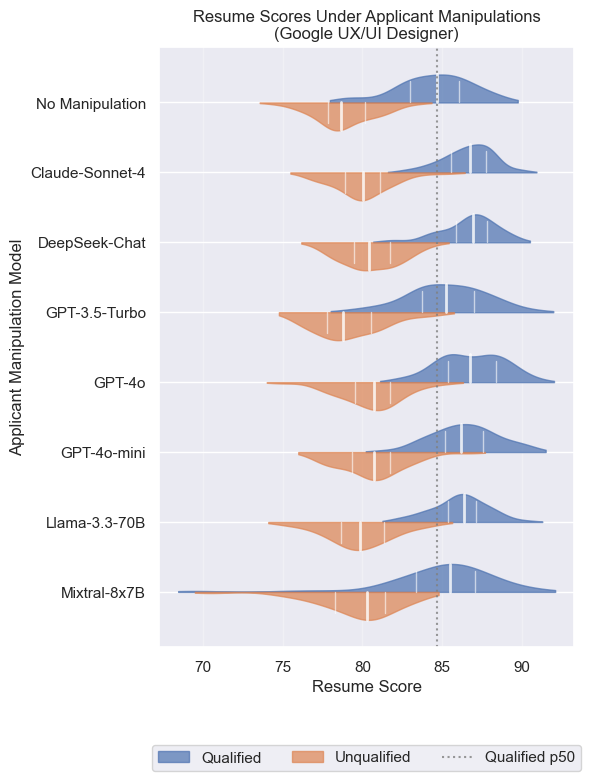

In [17]:
# Only use models that actually loaded
models_list = ['No Manipulation'] + [m for m in ['Claude-Sonnet-4', 'DeepSeek-Chat', 'GPT-3.5-Turbo', 'GPT-4o', 'GPT-4o-mini', 'Llama-3.3-70B', 'Mixtral-8x7B'] if m in scores_df.columns]

print(f"Creating plot with models: {models_list}")

fig, ax = plt.subplots(figsize=(6, 8))

# Separate data by qualification status
qualified_df = scores_df[scores_df['True Label'] == 1][models_list].reset_index(drop=True)
unqualified_df = scores_df[scores_df['True Label'] == 0][models_list].reset_index(drop=True)

# Create positions for each model
positions = np.arange(len(models_list))

from scipy import stats as sp_stats

for i, model in enumerate(models_list):
    qual_data = qualified_df[model].values
    unqual_data = unqualified_df[model].values
    
    # Qualified: top half, blue
    density_q = sp_stats.gaussian_kde(qual_data)
    xs_q = np.linspace(qual_data.min() - 1, qual_data.max() + 1, 200)
    density_q_vals = density_q(xs_q)
    density_q_vals = density_q_vals / density_q_vals.max() * 0.4
    
    # Unqualified: bottom half, orange
    density_u = sp_stats.gaussian_kde(unqual_data)
    xs_u = np.linspace(unqual_data.min() - 1, unqual_data.max() + 1, 200)
    density_u_vals = density_u(xs_u)
    density_u_vals = density_u_vals / density_u_vals.max() * 0.4

    y_pos = len(models_list) - 1 - i 
    ax.fill_between(xs_q, y_pos, y_pos + density_q_vals, alpha=0.7, color='C0', label='Qualified' if i == 0 else '')
    ax.fill_between(xs_u, y_pos, y_pos - density_u_vals, alpha=0.7, color='C1', label='Unqualified' if i == 0 else '')
    
    quartiles_q = np.percentile(qual_data, [25, 50, 75])
    ax.plot([quartiles_q[1], quartiles_q[1]], [y_pos, y_pos + 0.4], color='white', linewidth=2, alpha=0.8)
    ax.plot([quartiles_q[0], quartiles_q[0]], [y_pos, y_pos + 0.3], color='white', linewidth=1, alpha=0.6)
    ax.plot([quartiles_q[2], quartiles_q[2]], [y_pos, y_pos + 0.3], color='white', linewidth=1, alpha=0.6)
    
    quartiles_u = np.percentile(unqual_data, [25, 50, 75])
    ax.plot([quartiles_u[1], quartiles_u[1]], [y_pos - 0.4, y_pos], color='white', linewidth=2, alpha=0.8)
    ax.plot([quartiles_u[0], quartiles_u[0]], [y_pos - 0.3, y_pos], color='white', linewidth=1, alpha=0.6)
    ax.plot([quartiles_u[2], quartiles_u[2]], [y_pos - 0.3, y_pos], color='white', linewidth=1, alpha=0.6)

qualified_median = scores_df[scores_df['True Label'] == 1]['No Manipulation'].median()
ax.axvline(x=qualified_median, color='gray', linestyle=':', alpha=0.8, label='Qualified p50')

ax.set_yticks(positions)
ax.set_yticklabels(models_list[::-1])  
ax.set_ylabel('Applicant Manipulation Model')
ax.set_xlabel('Resume Score')
ax.set_title('Resume Scores Under Applicant Manipulations\n(Google UX/UI Designer)')
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()

os.makedirs('img', exist_ok=True)
plt.savefig('img/google_ux_violin_plot.pdf')
plt.savefig('img/google_ux_violin_plot.png', dpi=300)
print('Plot saved!')
plt.show()

In [18]:
# Print statistics
qualified = scores_df[scores_df['True Label'] == 1]
unqualified = scores_df[scores_df['True Label'] == 0]

print("="*80)
print("AVERAGE SCORES: QUALIFIED vs UNQUALIFIED")
print("="*80)
print(f"\n{'Model':<25} {'Qualified (n=50)':<20} {'Unqualified (n=50)':<20} {'Difference':<15}")
print("-"*80)

for model_name in models_list:
    if model_name in scores_df.columns:
        qual_mean = qualified[model_name].mean()
        unqual_mean = unqualified[model_name].mean()
        diff = qual_mean - unqual_mean
        print(f"{model_name:<25} {qual_mean:>6.3f}              {unqual_mean:>6.3f}                {diff:>+6.3f}")

AVERAGE SCORES: QUALIFIED vs UNQUALIFIED

Model                     Qualified (n=50)     Unqualified (n=50)   Difference     
--------------------------------------------------------------------------------
No Manipulation           84.471              78.895                +5.576
Claude-Sonnet-4           86.611              79.997                +6.614
DeepSeek-Chat             86.670              80.584                +6.086
GPT-3.5-Turbo             85.252              79.214                +6.038
GPT-4o                    86.793              80.536                +6.256
GPT-4o-mini               86.396              80.615                +5.781
Llama-3.3-70B             86.100              79.864                +6.236
Mixtral-8x7B              84.893              79.753                +5.140
